In [4]:
# essentials
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import os

import tensorflow as tf

import config
from utils.DataGenerator import DataGenerator

## Loading models and vocabulary

In [5]:
model = tf.keras.models.load_model(config.NN_MODEL_DIR + "model-acc16-loss4.91.h5")

In [ ]:
with open("vocabularies/vocabulary_small.pkl", 'rb') as file:
    vocabulary = pickle.load(file)

with open("models/word2vecs/whole-dataset-win7-vec200-min20.pkl", 'rb') as file:
    word2vec = pickle.load(file)

with open(os.path.join(config.NN_MODEL_DIR, "training_logs.pkl"), 'rb') as file:
    training_logs = pickle.load(file)

## Learning curve

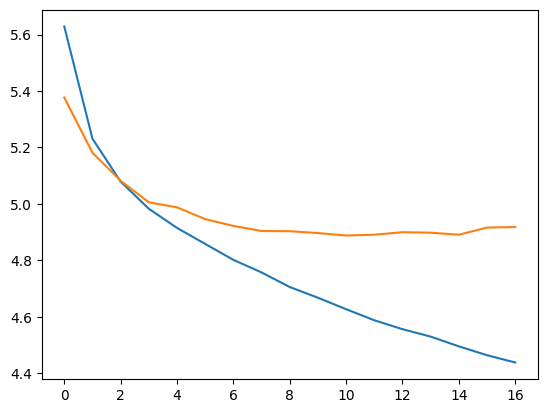

In [7]:
# due to early stopping executed epochs might be different
executed_epochs = len(training_logs.history["loss"])

plt.plot(range(executed_epochs), training_logs.history["loss"])
plt.plot(range(executed_epochs), training_logs.history["val_loss"])

## Evaluation 

In [8]:
reviews_df = pd.read_csv("data/reviews_cleaned_sample.csv", converters={'tokenized': pd.eval})

In [9]:
sample_index = 1

sample_reviews = reviews_df.tokenized.iloc[sample_index:sample_index+2]

In [10]:
data_gen = DataGenerator(sample_reviews, vocabulary=vocabulary)

In [11]:
X_words, y_words = data_gen.create_dataset(config.PREVIOUS_WORDS_CONSIDERED)
embedded_words = data_gen.vectorize(X_words, word2vec, input_size=config.INPUT_SIZE)

In [12]:
y_preds = model.predict(embedded_words)

num_proposed_words = 5
vocabulary_size = len(vocabulary)

5/5 [==============================] - 0s 6ms/step


In [13]:
pwc_and_predicted = []

for index in range(len(X_words)):
    y_pred = y_preds[index]

    predicted_indices = np.argsort(y_pred).reshape(vocabulary_size)[-num_proposed_words:]
    probabilities = np.sort(y_pred).reshape(vocabulary_size)[-num_proposed_words:]

    predicted_probability = {vocabulary[index]: prob for index, prob in zip(predicted_indices, probabilities)}
    
    pwc_and_predicted.append((X_words[index], y_words[index], predicted_probability))

In [14]:
pwc_and_predicted_sample = pwc_and_predicted[:5]

for tokens, _, predicted_words in pwc_and_predicted_sample:
    text = " ".join(tokens)

    print(text + "...")
    print("PREDICTED:")

    for word, probability in predicted_words.items():
        print("       {: >20}: {}%".format(word, int(probability*100)))

    print()

the favorite film...
PREDICTED:
                        but: 73%
                         to: 75%
                        and: 83%
                         of: 88%
                          i: 89%

favorite film of...
PREDICTED:
                         it: 75%
                       this: 76%
                          a: 83%
                        and: 85%
                        the: 94%

film of the...
PREDICTED:
                          i: 48%
                         is: 48%
                         in: 49%
                        the: 73%
                        and: 76%

actually more important...
PREDICTED:
                     things: 54%
                       than: 56%
                        and: 70%
                      films: 71%
                     movies: 79%

more important than...
PREDICTED:
                        you: 75%
                          a: 86%
                         it: 87%
                       this: 89%
                        the: 93%

